# ``Intervention Atlas``

**Augustinus, N.A., Moleman, M.L., & Susetya, F.D.**
<br>
*January, 2025*

Course: EPA221A Societal Challenge Project
<br>
Affilitation: Faculty Technology, Policy and Management, Delft University of Technology

## ``Import libraries``

In [38]:
import pandas as pd
import geopandas as gpd
import mapclassify
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from bs4 import BeautifulSoup
from urllib.request import urlopen
from io import StringIO 

import folium
from branca.colormap import linear

## ``Web scraping of intervention bank of NJI``

In [39]:
url = "https://www.nji.nl/interventies/incredible-years-en-invest-in-play"
page = urlopen(url)
html = page.read().decode("utf-8")
soup = BeautifulSoup(html, "html.parser")

In [40]:
title = soup.find_all(id="block-corp-page-title")
title = title[0].get_text().strip()

In [41]:
print(title)

Incredible Years en Invest in Play


In [42]:
description = soup.find_all("div", class_="node-intervention-full__lead-text-item text-filtered-html")
description = description[0].get_text().strip()

In [43]:
description

'Incredible Years is een interventie gericht op de opvoedingsvaardigheden van ouders van kinderen met gedragsproblemen of het risico daarop. Invest in Play – in Nederland Speel & Verbind\xa0– is de Europese doorontwikkeling van Incredible Years. Dit programma is cultuursensitief en sluit beter aan bij Nederlandse gezinnen.'

## ``Spatial data``

In [44]:
shapes = gpd.read_file('data/spatial/wijken.shp')

In [45]:
shapes = shapes[['WK_CODE', 'WK_NAAM', 'GM_CODE', 'geometry']]

In [46]:
shapes = shapes[shapes['GM_CODE'] == 'GM0518']

<Axes: >

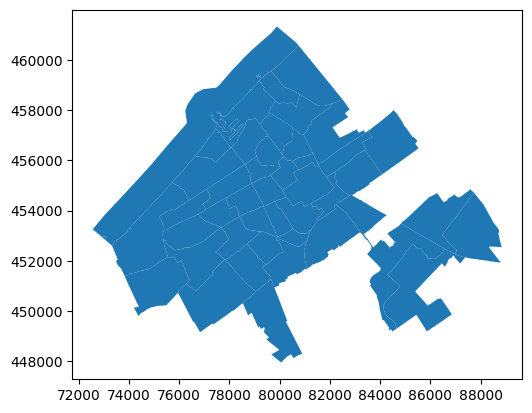

In [47]:
shapes.plot()

## ``Kerncijfers``

In [48]:
kerncijfers = pd.read_csv("data/kerncijfers den haag.csv", delimiter = ';')

In [49]:
char = kerncijfers['WK_CODE'].str.contains('WK')
kerncijfers_wijken = kerncijfers[char]

In [50]:
kerncijfers_wijken.head(5)

,WK_NAAM,WK_CODE,INWONERS,MANNEN,VROUWEN,AANTAL_0_15_JAAR,AANTAL_15_25_JAAR,AANTAL_25_45_JAAR,AANTAL_45_65_JAAR,AANTAL_65_PLUS,WESTERSE_ACHTERGROND,NIET_WESTERSE_ACHTERGROND,ARBEIDSPARTICIPATIE
1,Wijk 01 Oostduinen,WK051801,0,0,0,0,0,0,0,0,0,0,.
3,Wijk 02 Belgisch Park,WK051802,8260,4050,4205,1250,1150,1805,2350,1705,1990,1105,62
5,Wijk 03 Westbroekpark en Duttendel,WK051803,2145,960,1185,250,185,250,535,925,555,180,54
8,Wijk 04 Benoordenhout,WK051804,14540,6840,7700,2645,1250,3010,3765,3870,4230,1695,65
15,Wijk 05 Archipelbuurt,WK051805,6065,2870,3195,750,610,1430,1840,1435,1795,735,61


## ``Risicojongeren``

In [51]:
risicojongeren = pd.read_excel("data/risicojongeren den haag.xlsx", sheet_name = "Data")

## ``Merge data``

In [52]:
data = pd.merge(kerncijfers_wijken, risicojongeren, on='WK_CODE', how='left')

In [53]:
data = pd.merge(data, shapes, on='WK_CODE', how='left')

## ``Modify data``

In [54]:
data = data[['WK_NAAM', 'WK_CODE', 'INWONERS', 'MANNEN', 'VROUWEN', 'AANTAL_0_15_JAAR', 'AANTAL_15_25_JAAR', 'AANTAL_25_45_JAAR', 
             'AANTAL_45_65_JAAR', 'AANTAL_65_PLUS', 'WESTERSE_ACHTERGROND', 'NIET_WESTERSE_ACHTERGROND', 'ARBEIDSPARTICIPATIE', 
             'RISICOJONGEREN', 'geometry']]

In [55]:
focusgebieden = ['Wijk 33 Bouwlust en Vrederus', 'Wijk 34 Morgenstond', 'Wijk 35 Zuiderpark', 'Wijk 36 Moerwijk']

In [56]:
data['FOCUSGEBIED'] = data['WK_NAAM'].apply(lambda x: 1 if x in focusgebieden else 0)

In [57]:
interventiegebieden = ['Wijk 30 Transvaalkwartier', 'Wijk 36 Moerwijk', 'Wijk 38 Laakkwartier en Spoorwijk']

In [58]:
data['AJB'] = data['WK_NAAM'].apply(lambda x: 2 if x in interventiegebieden else 0)

In [59]:
data['INTERVENTION'] = data['FOCUSGEBIED'] + data['AJB']

In [60]:
data = gpd.GeoDataFrame(data, geometry='geometry', crs="EPSG:28992")

In [61]:
data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   WK_NAAM                    44 non-null     object  
 1   WK_CODE                    44 non-null     object  
 2   INWONERS                   44 non-null     int64   
 3   MANNEN                     44 non-null     int64   
 4   VROUWEN                    44 non-null     int64   
 5   AANTAL_0_15_JAAR           44 non-null     int64   
 6   AANTAL_15_25_JAAR          44 non-null     int64   
 7   AANTAL_25_45_JAAR          44 non-null     int64   
 8   AANTAL_45_65_JAAR          44 non-null     int64   
 9   AANTAL_65_PLUS             44 non-null     int64   
 10  WESTERSE_ACHTERGROND       44 non-null     int64   
 11  NIET_WESTERSE_ACHTERGROND  44 non-null     int64   
 12  ARBEIDSPARTICIPATIE        44 non-null     object  
 13  RISICOJONGEREN             36

In [62]:
data

,WK_NAAM,WK_CODE,INWONERS,MANNEN,VROUWEN,AANTAL_0_15_JAAR,AANTAL_15_25_JAAR,AANTAL_25_45_JAAR,AANTAL_45_65_JAAR,AANTAL_65_PLUS,WESTERSE_ACHTERGROND,NIET_WESTERSE_ACHTERGROND,ARBEIDSPARTICIPATIE,RISICOJONGEREN,geometry,FOCUSGEBIED,AJB,INTERVENTION
0,Wijk 01 Oostduinen,WK051801,0,0,0,0,0,0,0,0,0,0,.,NaN,"POLYGON ((80759.259 460561.174, 80775.924 4605...",0,0,0
1,Wijk 02 Belgisch Park,WK051802,8260,4050,4205,1250,1150,1805,2350,1705,1990,1105,62,3.4,"POLYGON ((79479.473 459565.29, 79479.521 45956...",0,0,0
2,Wijk 03 Westbroekpark en Duttendel,WK051803,2145,960,1185,250,185,250,535,925,555,180,54,NaN,"POLYGON ((80506.54 457307.14, 80482.96 457322....",0,0,0
3,Wijk 04 Benoordenhout,WK051804,14540,6840,7700,2645,1250,3010,3765,3870,4230,1695,65,0.9,"POLYGON ((81121.32 456683.39, 81099.05 456727....",0,0,0
4,Wijk 05 Archipelbuurt,WK051805,6065,2870,3195,750,610,1430,1840,1435,1795,735,61,2.7,"POLYGON ((80532.57 457257.845, 80534.45 457257...",0,0,0
5,Wijk 06 Van Stolkpark en Scheveningse Bosjes,WK051806,780,380,405,110,75,140,240,210,265,100,56,NaN,"POLYGON ((79589.65 457897.43, 79590.82 457897....",0,0,0
6,Wijk 07 Scheveningen,WK051807,18370,8905,9465,2660,1720,5345,4970,3680,3795,2240,64,5.7,"POLYGON ((78406.444 458331.742, 78447.849 4583...",0,0,0
7,Wijk 08 Duindorp,WK051808,5790,2875,2915,1035,550,1550,1745,915,710,400,66,10.5,"POLYGON ((77547.868 457169.704, 77541.2 457161...",0,0,0
8,Wijk 09 Geuzen- en Statenkwartier,WK051809,14215,6820,7400,2405,1565,3500,4075,2685,4365,1735,64,2.8,"POLYGON ((78881.42 457631.89, 78895.67 457635....",0,0,0
9,Wijk 10 Zorgvliet,WK051810,665,340,335,85,40,110,180,250,230,75,49,NaN,"POLYGON ((79575.76 456937.04, 79578.4 456936.4...",0,0,0


## ``Visualize data``

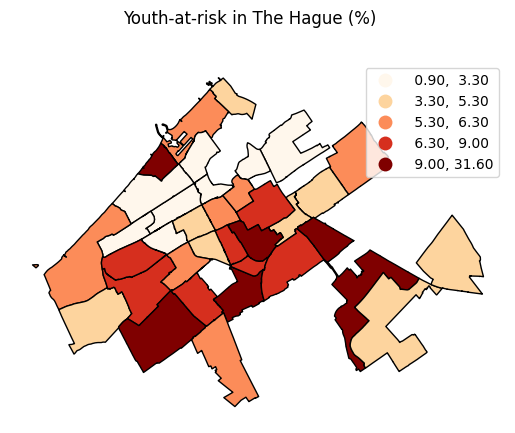

In [63]:
f, ax = plt.subplots(1)
data.plot(column="RISICOJONGEREN", scheme="quantiles", k=5, cmap="OrRd", edgecolor="k", legend=True, ax = ax)
ax.set_axis_off()
f.suptitle('Youth-at-risk in The Hague (%)')
plt.savefig('images/fig_risicojongeren.png', bbox_inches='tight')
plt.show()

In [64]:
data['INTERVENTION'] = data['INTERVENTION'].replace({0: 'Neither', 1: 'Focus area', 2: 'AJB location', 3:'Focus area & AJB location'})

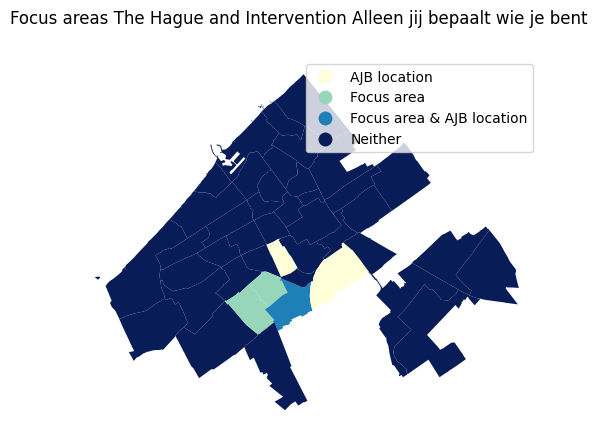

In [65]:
f, ax = plt.subplots(1)
data.plot(column='INTERVENTION', categorical=True, legend=True, cmap='YlGnBu', ax=ax)
ax.set_axis_off()
f.suptitle('Focus areas The Hague and Intervention Alleen jij bepaalt wie je bent')
plt.savefig('images/fig_mismatches.png', bbox_inches='tight')
plt.show()

## ``Interactive spatial map``

In [66]:
data['ACHTERGROND'] = data['WESTERSE_ACHTERGROND'] + data['NIET_WESTERSE_ACHTERGROND']

In [67]:
data['GEEN_ACHTERGROND'] = data['INWONERS'] - data['WESTERSE_ACHTERGROND'] - data['NIET_WESTERSE_ACHTERGROND']

In [69]:
columns = ['MANNEN', 'VROUWEN', 'AANTAL_0_15_JAAR', 'AANTAL_15_25_JAAR', 'AANTAL_25_45_JAAR', 'AANTAL_45_65_JAAR', 'AANTAL_65_PLUS', 
           'GEEN_ACHTERGROND', 'WESTERSE_ACHTERGROND', 'NIET_WESTERSE_ACHTERGROND']

for column in columns: 
    data[column] = data[column] / data['INWONERS'] * 100

In [70]:
data = data.round({'MANNEN': 1, 'VROUWEN': 1, 'AANTAL_0_15_JAAR': 1, 'AANTAL_15_25_JAAR': 1, 'AANTAL_25_45_JAAR': 1, 'AANTAL_45_65_JAAR': 1, 
                   'AANTAL_65_PLUS': 1, 'ACHTERGROND': 1, 'GEEN_ACHTERGROND': 1, 'WESTERSE_ACHTERGROND': 1, 'NIET_WESTERSE_ACHTERGROND': 1})

data['AJB'] = data['AJB'].apply(lambda x: 'Ja' if x==2 else 'Nee')
data['FOCUSGEBIED'] = data['FOCUSGEBIED'].apply(lambda x: 'Ja' if x==1 else 'Nee')

data = data[['WK_NAAM', 'MANNEN', 'VROUWEN', 'AANTAL_0_15_JAAR', 'AANTAL_15_25_JAAR', 'AANTAL_25_45_JAAR', 'AANTAL_45_65_JAAR', 
             'AANTAL_65_PLUS', 'GEEN_ACHTERGROND', 'WESTERSE_ACHTERGROND', 'NIET_WESTERSE_ACHTERGROND', 'ARBEIDSPARTICIPATIE', 'RISICOJONGEREN', 
             'FOCUSGEBIED', 'AJB', 'geometry']]

data['WK_NAAM'] = data['WK_NAAM'].str.split().str[-1]

data.columns = ['Buurt', 'Man (%)', 'Vrouw (%)', 'Leeftijd 0-15 jaar (%)', 'Leeftijd 15-25 jaar (%)', 'Leeftijd 25-45 jaar (%)', 
                'Leeftijd 45-64 jaar (%)', 'Leeftijd 65+ jaar (%)', 'Geen migratieachtergrond (%)', 'Westerse migratieachtergrond (%)', 
                'Niet-westerse migratieachtergrond (%)', 'Arbeidsparticipatie (%)', 'Risicojongeren (%)', 'Focusgebied', 
                'Interventie Alleen jij bepaalt', 'geometry']

In [71]:
data

,Buurt,Man (%),Vrouw (%),Leeftijd 0-15 jaar (%),Leeftijd 15-25 jaar (%),Leeftijd 25-45 jaar (%),Leeftijd 45-64 jaar (%),Leeftijd 65+ jaar (%),Geen migratieachtergrond (%),Westerse migratieachtergrond (%),Niet-westerse migratieachtergrond (%),Arbeidsparticipatie (%),Risicojongeren (%),Focusgebied,Interventie Alleen jij bepaalt,geometry
0,Oostduinen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,.,NaN,Nee,Nee,"POLYGON ((80759.259 460561.174, 80775.924 4605..."
1,Park,49.0,50.9,15.1,13.9,21.9,28.5,20.6,62.5,24.1,13.4,62,3.4,Nee,Nee,"POLYGON ((79479.473 459565.29, 79479.521 45956..."
2,Duttendel,44.8,55.2,11.7,8.6,11.7,24.9,43.1,65.7,25.9,8.4,54,NaN,Nee,Nee,"POLYGON ((80506.54 457307.14, 80482.96 457322...."
3,Benoordenhout,47.0,53.0,18.2,8.6,20.7,25.9,26.6,59.3,29.1,11.7,65,0.9,Nee,Nee,"POLYGON ((81121.32 456683.39, 81099.05 456727...."
4,Archipelbuurt,47.3,52.7,12.4,10.1,23.6,30.3,23.7,58.3,29.6,12.1,61,2.7,Nee,Nee,"POLYGON ((80532.57 457257.845, 80534.45 457257..."
5,Bosjes,48.7,51.9,14.1,9.6,17.9,30.8,26.9,53.2,34.0,12.8,56,NaN,Nee,Nee,"POLYGON ((79589.65 457897.43, 79590.82 457897...."
6,Scheveningen,48.5,51.5,14.5,9.4,29.1,27.1,20.0,67.1,20.7,12.2,64,5.7,Nee,Nee,"POLYGON ((78406.444 458331.742, 78447.849 4583..."
7,Duindorp,49.7,50.3,17.9,9.5,26.8,30.1,15.8,80.8,12.3,6.9,66,10.5,Nee,Nee,"POLYGON ((77547.868 457169.704, 77541.2 457161..."
8,Statenkwartier,48.0,52.1,16.9,11.0,24.6,28.7,18.9,57.1,30.7,12.2,64,2.8,Nee,Nee,"POLYGON ((78881.42 457631.89, 78895.67 457635...."
9,Zorgvliet,51.1,50.4,12.8,6.0,16.5,27.1,37.6,54.1,34.6,11.3,49,NaN,Nee,Nee,"POLYGON ((79575.76 456937.04, 79578.4 456936.4..."


In [72]:
data = data.to_crs(epsg = 4326)

m = folium.Map(
    location = [52.0705, 4.3007],
    zoom_start = 12,
    zoom_control = False,
    scrollWheelZoom = False,
    dragging = False,
    tiles = "CartoDB Voyager"
)

# Makes a choropleth of youth-at-risk statistics in The Hague 
folium.Choropleth(
    geo_data = data.to_json(),
    name = "Choropleth",
    data = data,
    columns = ["Buurt", "Risicojongeren (%)"], 
    key_on = "feature.properties.Buurt",  
    fill_color = "YlOrRd", 
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = "Risicojongeren (%)",
    highlight = True, 
    nan_fill_color = "gray", 
    bins = 5,  
).add_to(m)

# Highlights districts with other statistics as well
for _, row in data.iterrows():
    geom = row['geometry']
    properties = row.drop('geometry').to_dict() 
    popup_content = "<br>".join([f"<b>{key}:</b> {value}" for key, value in properties.items()])

    folium.GeoJson(
        geom,
        name = row['Buurt'],
        tooltip = folium.Tooltip(popup_content),
        style_function = lambda feature: {
            'fillOpacity': 0, 
            'weight': 0,  
            'color': 'transparent' 
        },
        highlight_function = lambda feature: {
            'fillOpacity': 0.1,  
            'weight': 1, 
            'color': 'black' 
        }
    ).add_to(m)

m.save("intervention_atlas.html")

In [73]:
m